<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi, empresa brasileira de entregas e serviços, enfrenta um desafio crescente no Distrito Federal: a alta demanda por seus serviços. Sem uma análise cuidadosa, essa demanda pode levar à desorganização e ineficiência. É aí que entra a análise de dados, uma ferramenta poderosa para otimizar as operações da empresa e garantir a excelência na prestação de serviços.

Portanto, visando a melhora desses serviços no Distrito Federal, a Loggi disponibilizou uma série de dados de entregas no formato JSON. Dado o contexto, iniciaremos nossas análises, buscando responder as seguintes peguntas.


*   Coorelação entre local de entrega e os hubs.
*   posicionamento geografico dos hubs.
*   O peso das entregas com a capacidade de armazenamento dos hubs.







## 2\. Pacotes e bibliotecas

No intuito de aprimorar a qualidade do tratamento dos dados, foram importadas algumas bibliotecas específicas.

In [ ]:
!pip3 install geopandas;
!pip3 install geopy;
# pacotes nativos do python
import json
#  pacotes de terceiros
import pandas as pd
import geopy
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.point import Point
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

Aqui estão os links para o download de todos os dados, que iremos usar nas análises e dados para ajudar no enriquecimento da visualização de dados posterior mente.

In [ ]:
# download dos dados
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

## 3\. Exploração de dados

Aqui vamos trazer os dados disponibilizados no Python e vamos realizar a exploração desses dados, organizando-os e deixando-os em um Dataframe.

In [ ]:
# trazendo os dados para o python
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")

#coluna origin
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

#coluna deliveries
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

## 4\. Manipulação

Após o DataFrame já estiver organizado, iremos trazer mais informações de interesse para a análise, usando os dados da latitude e longitude disponibilizados pela Loggi e o Nominatim para retirarmos informações como a cidade e subúrbio dos hubs e das entregas.

In [ ]:
#enriquecimento
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)


geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

## 5\. Visualização

Estamos configurando o mapa para a primeira visualização. O mapa mostra apenas a região de estudo, o Distrito Federal.

In [ ]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

1. Visualização das entregas na região de Brasília, divididas por hubs.

*    O mapa mostra apenas os locais dos hubs e das entregas.
*   Os hubs são representados pelo símbolo "X" no mapa.
*   As entregas são representadas por pontos no mapa.
*   As entregas de cada hub são representadas por cores diferentes:
    *   Vermelho: DF-0
    *   Azul: DF-1
    *   Verde: DF-02




<ipython-input-6-71a3b10e037c>:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


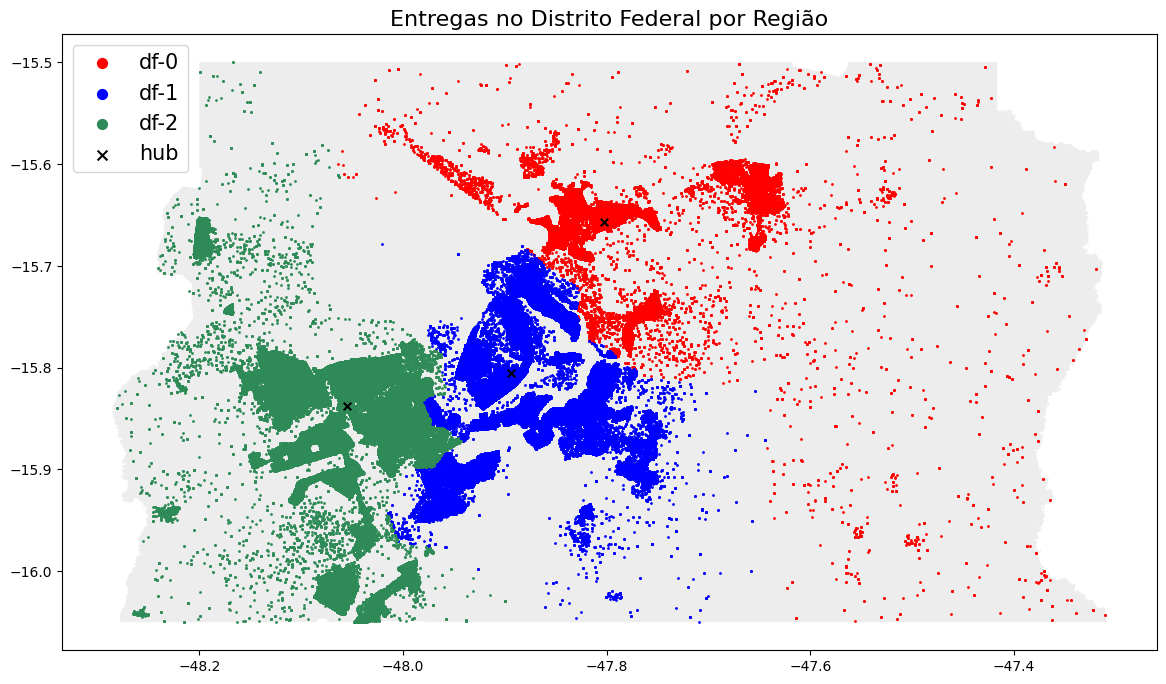

In [ ]:
fig, ax = plt.subplots(figsize = (50/3.54, 50/3.54))
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

# Insights

* Nos locais onde as regiões de entrega se encontram, é notável que ocorre uma confusão que faz com que hubs de uma região distinta realizem entregas mais a dentro do território de outro hub, principalmente em locais mais afastados dos focos de entregas. Por isso, é notável que seria interessante para a empresa realizar uma melhor gestão das áreas de entrega de cada hub, promovendo uma melhor gestão de tempo e gastos nas entregas.



*   A região DF-0 apresenta um maior número de entregas distantes do hub principal. Essa distância pode ocasionar atrasos nos prazos de entrega para essa região.
 Nesse contexto, é interessante que a empresa invista em carros mais econômicos e de menor porte para atender a essa demanda. Já nos hubs DF-1 e DF-2, é importante investir em veículos com maior capacidade de carga, a fim de reduzir o número de viagens necessárias para realizar as entregas.

*  Decorente da alta quantidade de entregas nas regiões pode ser interesante a loggi criar mais hubs, promovendo melhor distibuição das entregas.  





---






2.   Visualização da porcentagem de entregas por região.













<ipython-input-7-df1116dd5124>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=soma_delivery, x='region',y='size_percent',ci=None,palette='pastel')
<ipython-input-7-df1116dd5124>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=soma_delivery, x='region',y='size_percent',ci=None,palette='pastel')


[Text(0.5, 1.0, 'porcentagem do peso das entregas por região'),
 Text(0.5, 0, 'região'),
 Text(0, 0.5, 'porcentagem entregas')]

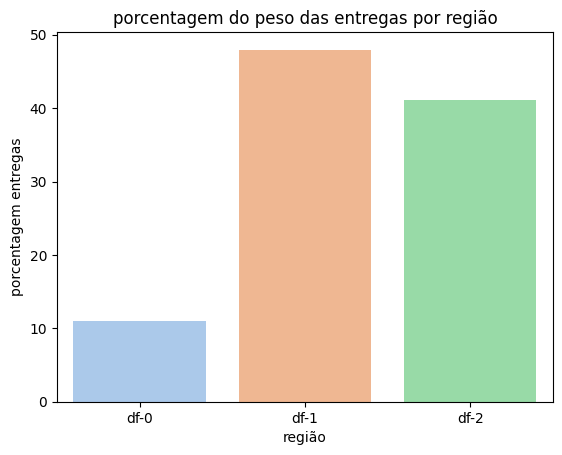

In [ ]:
soma_delivery = deliveries_df[['region','delivery_size']].groupby('region').agg('sum').reset_index()
soma_delivery ['size_percent'] = 100 * soma_delivery['delivery_size'] / soma_delivery['delivery_size'].sum()
grafico = sns.barplot(data=soma_delivery, x='region',y='size_percent',ci=None,palette='pastel')
grafico.set(title='porcentagem do peso das entregas por região',xlabel='região',ylabel='porcentagem entregas')



3.  Visualização da capacidade de entrega por região.




<ipython-input-8-c478c2e455bc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=soma_size_hub,x='region',y='size_percent',palette='pastel')


[Text(0.5, 1.0, 'porcentagem do capacidade de entregas de cada hub'),
 Text(0.5, 0, 'regiao'),
 Text(0, 0.5, 'porcentagem capacidade hub')]

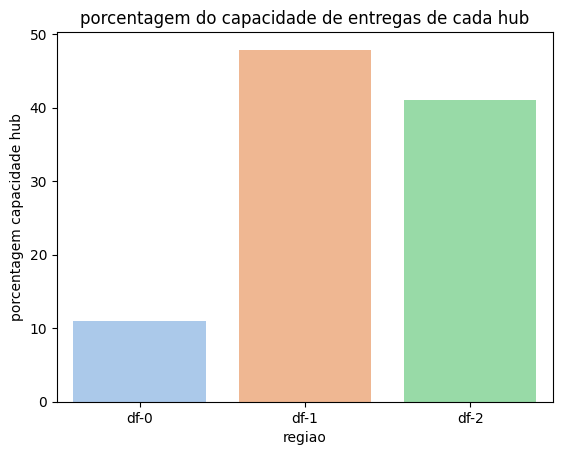

In [ ]:
soma_size_hub = deliveries_df[['region','vehicle_capacity']].groupby('region').agg('sum').reset_index()
soma_size_hub['size_percent'] = 100 * soma_size_hub['vehicle_capacity'] / soma_size_hub['vehicle_capacity'].sum()
grafico = sns.barplot(data=soma_size_hub,x='region',y='size_percent',palette='pastel')
grafico.set(title='porcentagem do capacidade de entregas de cada hub',xlabel='regiao',ylabel='porcentagem capacidade hub')

# Insights

*  Abertura de novos pontos de entrega em DF-0: Essa medida visa aumentar a capilaridade da empresa na região, reduzindo o tempo e o custo das entregas, além de oferecer maior comodidade aos clientes.
*   Análise estratégica de localizações: A escolha dos locais para os novos pontos deve considerar fatores como demanda por entregas, densidade populacional, acessibilidade e infraestrutura local.

*   Implementação de um sistema de roteirização otimizada: Essa ferramenta permite organizar as entregas de forma eficiente, reduzindo o tempo de deslocamento e otimizando o uso dos recursos da empresa.


*   Manutenção e aprimoramento do sistema de gestão de cargas: É importante monitorar constantemente a demanda e ajustar a capacidade de entrega em cada região, garantindo que a empresa esteja sempre preparada para atender às necessidades dos clientes.








